# Reconstructing an Interbank Trust Network to Analyze Systemic Risk (2014–2019)

## Project Overview

Modern financial systems are highly interconnected through interbank lending markets. 
While individual banks may appear stable in isolation, hidden dependencies can amplify 
financial shocks and lead to systemic crises.

This project reconstructs a dynamic interbank trust network using balance-sheet data 
from 2014 to 2019 and analyzes how changes in network structure influence systemic risk.

### Objectives
- Reconstruct yearly interbank networks from balance-sheet data
- Model interbank trust as a latent network weight
- Analyze the evolution of network structure over time
- Simulate contagion and assess systemic risk


### Why Network Reconstruction?

The dataset does not provide bilateral interbank exposures.
To analyze systemic risk, we reconstruct a plausible interbank network by allocating
aggregate interbank lending to borrowing banks proportionally.

This approach is widely used in systemic risk literature when detailed exposure matrices
are unavailable.


### Data Conversion & Loading

The original dataset is provided as yearly Excel files (2014–2019).
To ensure reproducibility, portability, and faster I/O operations, all files
are first converted into CSV format and then loaded into the analysis pipeline.

Each year is processed independently to avoid temporal leakage.


In [780]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [781]:
BASE_PATH = Path(r"C:\Users\cw\OneDrive\Desktop\Interbank")

years = range(2014, 2020)

In [782]:
data = {}

for year in years:
    file_path = BASE_PATH / f"{year}.csv"
    df = pd.read_csv(file_path)
    
    df["Year"] = year  # add year for reference
    data[year] = df

print("Loaded datasets for years:", list(data.keys()))


Loaded datasets for years: [2014, 2015, 2016, 2017, 2018, 2019]


In [783]:
data[2014].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16142 entries, 0 to 16141
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank_Name               344 non-null    object
 1   Deposit_To_Interbank    344 non-null    object
 2   Interbank_Lending       344 non-null    object
 3   Total_Assets            344 non-null    object
 4   Deposit_From_Interbank  344 non-null    object
 5   Interbank_Borrowing     344 non-null    object
 6   Total_Liabilities       344 non-null    object
 7   Total_Equities          344 non-null    object
 8   Date                    344 non-null    object
 9   Year                    16142 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


In [784]:
for year, df in data.items():
    print(f"{year}: {df.shape}")

2014: (16142, 10)
2015: (16173, 10)
2016: (386, 10)
2017: (16182, 10)
2018: (16159, 10)
2019: (16128, 10)


In [785]:
for year, df in data.items():
    print(year, df.columns.tolist())

2014 ['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending', 'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing', 'Total_Liabilities', 'Total_Equities', 'Date', 'Year']
2015 ['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending', 'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing', 'Total_Liabilities', 'Total_Equities', 'Date', 'Year']
2016 ['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending', 'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing', 'Total_Liabilities', 'Total_Equities', 'Date', 'Year']
2017 ['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending', 'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing', 'Total_Liabilities', 'Total_Equities', 'Date', 'Year']
2018 ['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending', 'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing', 'Total_Liabilities', 'Total_Equities', 'Date', 'Year']
2019 ['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending', 'Total_Assets', 

### Data Type Conversion

In [787]:
# Columns expected to be numeric
numeric_cols = [
    "Interbank_Lending",
    "Interbank_Borrowing",
    "Deposit_To_Interbank",
    "Deposit_From_Interbank",
    "Total_Assets",
    "Total_Liabilities",
    "Total_Equities"
]

for year, df in data.items():
    
    # Bank name as string
    df["Bank_Name"] = df["Bank_Name"].astype(str)
    
    # Convert numeric columns safely
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Year as integer
    df["Year"] = df["Year"].astype(int)


In [788]:
for year, df in data.items():
    print(f"\nData types for {year}:")
    print(df.dtypes)



Data types for 2014:
Bank_Name                  object
Deposit_To_Interbank      float64
Interbank_Lending         float64
Total_Assets              float64
Deposit_From_Interbank    float64
Interbank_Borrowing       float64
Total_Liabilities         float64
Total_Equities            float64
Date                       object
Year                        int32
dtype: object

Data types for 2015:
Bank_Name                  object
Deposit_To_Interbank      float64
Interbank_Lending         float64
Total_Assets              float64
Deposit_From_Interbank    float64
Interbank_Borrowing       float64
Total_Liabilities         float64
Total_Equities            float64
Date                       object
Year                        int32
dtype: object

Data types for 2016:
Bank_Name                  object
Deposit_To_Interbank      float64
Interbank_Lending         float64
Total_Assets              float64
Deposit_From_Interbank    float64
Interbank_Borrowing       float64
Total_Liabilities     

In [789]:
for year, df in data.items():
    print(f"\n Missing value for {year}:")
    print(df.isnull().sum())


 Missing value for 2014:
Bank_Name                     0
Deposit_To_Interbank      16124
Interbank_Lending         15953
Total_Assets              16142
Deposit_From_Interbank    16102
Interbank_Borrowing       15947
Total_Liabilities         16142
Total_Equities            16141
Date                      15798
Year                          0
dtype: int64

 Missing value for 2015:
Bank_Name                     0
Deposit_To_Interbank      16143
Interbank_Lending         15973
Total_Assets              16173
Deposit_From_Interbank    16126
Interbank_Borrowing       15968
Total_Liabilities         16173
Total_Equities            16173
Date                      15798
Year                          0
dtype: int64

 Missing value for 2016:
Bank_Name                   0
Deposit_To_Interbank      356
Interbank_Lending         209
Total_Assets              386
Deposit_From_Interbank    346
Interbank_Borrowing       193
Total_Liabilities         386
Total_Equities            384
Date            

#### Measure Missingness Ratio (Per Year)

In [791]:
for year, df in data.items():
    print(f"\n Missing Rate for the year {year}:")
    print((df.isna().mean() * 100). round(2))    


 Missing Rate for the year 2014:
Bank_Name                   0.00
Deposit_To_Interbank       99.89
Interbank_Lending          98.83
Total_Assets              100.00
Deposit_From_Interbank     99.75
Interbank_Borrowing        98.79
Total_Liabilities         100.00
Total_Equities             99.99
Date                       97.87
Year                        0.00
dtype: float64

 Missing Rate for the year 2015:
Bank_Name                   0.00
Deposit_To_Interbank       99.81
Interbank_Lending          98.76
Total_Assets              100.00
Deposit_From_Interbank     99.71
Interbank_Borrowing        98.73
Total_Liabilities         100.00
Total_Equities            100.00
Date                       97.68
Year                        0.00
dtype: float64

 Missing Rate for the year 2016:
Bank_Name                   0.00
Deposit_To_Interbank       92.23
Interbank_Lending          54.15
Total_Assets              100.00
Deposit_From_Interbank     89.64
Interbank_Borrowing        50.00
Total_Liab

#### Drop Rows With No Financial Information

### Missing Value Handling

Due to heterogeneous reporting across years, missing values were handled
using a hybrid strategy:
- Rows with no financial signal were removed
- Remaining missing financial values were imputed using year-wise medians
- Date column was dropped due to insufficient temporal granularity

This approach preserves network structure while avoiding artificial edge creation.


In [794]:
financial_cols = [
    "Deposit_To_Interbank",
    "Interbank_Lending",
    "Deposit_From_Interbank",
    "Interbank_Borrowing",
    "Total_Assets",
    "Total_Liabilities",
    "Total_Equities"
]

for year, df in data.items():
    df.dropna(subset= financial_cols, how = 'all', inplace = True)

In [795]:
for year, df in data.items():
    for col in financial_cols:
        if col in df.columns:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            

In [796]:
for year, df in data.items():
    if 'Date' in df.columns:
        df.drop(columns=['Date'], inplace = True)

In [797]:
for year, df in data.items():
    print(f"\nRemaining NaNs in {year}:")
    print(df.isna().sum())



Remaining NaNs in 2014:
Bank_Name                   0
Deposit_To_Interbank        0
Interbank_Lending           0
Total_Assets              239
Deposit_From_Interbank      0
Interbank_Borrowing         0
Total_Liabilities         239
Total_Equities              0
Year                        0
dtype: int64

Remaining NaNs in 2015:
Bank_Name                   0
Deposit_To_Interbank        0
Interbank_Lending           0
Total_Assets              260
Deposit_From_Interbank      0
Interbank_Borrowing         0
Total_Liabilities         260
Total_Equities            260
Year                        0
dtype: int64

Remaining NaNs in 2016:
Bank_Name                   0
Deposit_To_Interbank        0
Interbank_Lending           0
Total_Assets              241
Deposit_From_Interbank      0
Interbank_Borrowing         0
Total_Liabilities         241
Total_Equities              0
Year                        0
dtype: int64

Remaining NaNs in 2017:
Bank_Name                   0
Deposit_To_Interbank 

### Total Assets = Total Liabilities + Total Equities

In [799]:
for year, df in data.items():
    
    # Assets missing
    mask = df["Total_Assets"].isna() & df["Total_Liabilities"].notna() & df["Total_Equities"].notna()
    df.loc[mask, "Total_Assets"] = (
        df.loc[mask, "Total_Liabilities"] + df.loc[mask, "Total_Equities"]
    )
    
    # Liabilities missing
    mask = df["Total_Liabilities"].isna() & df["Total_Assets"].notna() & df["Total_Equities"].notna()
    df.loc[mask, "Total_Liabilities"] = (
        df.loc[mask, "Total_Assets"] - df.loc[mask, "Total_Equities"]
    )
    
    # Equities missing
    mask = df["Total_Equities"].isna() & df["Total_Assets"].notna() & df["Total_Liabilities"].notna()
    df.loc[mask, "Total_Equities"] = (
        df.loc[mask, "Total_Assets"] - df.loc[mask, "Total_Liabilities"]
    )


### Balance-Sheet Consistency Enforcement

Missing balance-sheet variables were reconstructed using the accounting
identity Assets = Liabilities + Equities wherever possible. Observations
with insufficient information to satisfy this identity were removed to
avoid financially inconsistent records.


for year, df in data.items():
    print(f"\nAfter balance-sheet recovery {year}:")
    print(df[["Total_Assets", "Total_Liabilities", "Total_Equities"]].isna().sum())


In [802]:
for year, df in data.items():
    df.dropna(
        subset=["Total_Assets", "Total_Liabilities", "Total_Equities"],
        how="any",
        inplace=True
    )


In [803]:
for year, df in data.items():
    print(f"\nAfter balance-sheet recovery {year}:")
    print(df[["Total_Assets", "Total_Liabilities", "Total_Equities"]].isna().sum())


After balance-sheet recovery 2014:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2015:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2016:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2017:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2018:
Total_Assets         0
Total_Liabilities    0
Total_Equities       0
dtype: int64

After balance-sheet recovery 2019:
Total_Assets         0
Total_Liabilities    0
Total_Equities       0
dtype: int64


In [804]:
for year, df in data.items():
    df.dropna(subset=["Total_Assets"], inplace=True)


In [805]:
for year, df in data.items():
    print(f"\nAfter balance-sheet recovery {year}:")
    print(df[["Total_Assets", "Total_Liabilities", "Total_Equities"]].isna().sum())


After balance-sheet recovery 2014:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2015:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2016:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2017:
Total_Assets         0.0
Total_Liabilities    0.0
Total_Equities       0.0
dtype: float64

After balance-sheet recovery 2018:
Total_Assets         0
Total_Liabilities    0
Total_Equities       0
dtype: int64

After balance-sheet recovery 2019:
Total_Assets         0
Total_Liabilities    0
Total_Equities       0
dtype: int64


#### Banks without reported total assets were removed, as balance-sheet size is essential for systemic risk normalization and exposure scaling.

#### Bank Coverage Across Years

In [808]:
bank_counts = {
    year: df["Bank_Name"].nunique()
    for year, df in data.items()
}

bank_counts


{2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 9, 2019: 9}

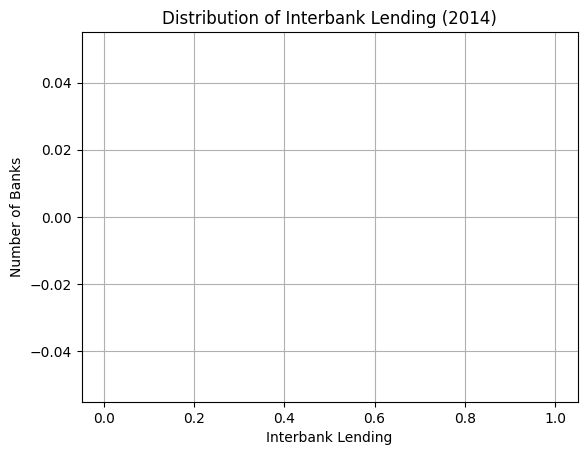

In [809]:
plt.figure()
data[2014]["Interbank_Lending"].hist(bins=30)
plt.title("Distribution of Interbank Lending (2014)")
plt.xlabel("Interbank Lending")
plt.ylabel("Number of Banks")
plt.show()


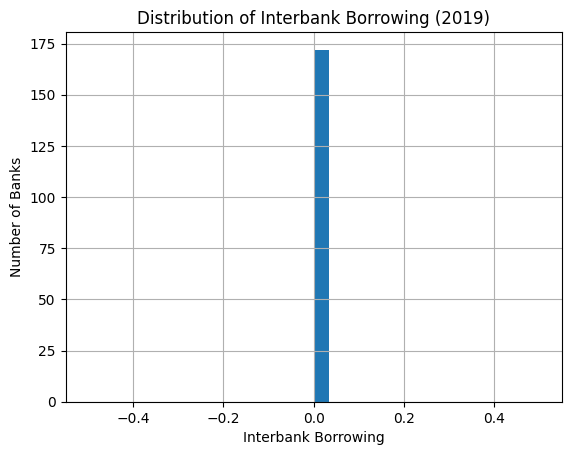

In [810]:
plt.figure()
data[2019]["Interbank_Borrowing"].hist(bins=30)
plt.title("Distribution of Interbank Borrowing (2019)")
plt.xlabel("Interbank Borrowing")
plt.ylabel("Number of Banks")
plt.show()


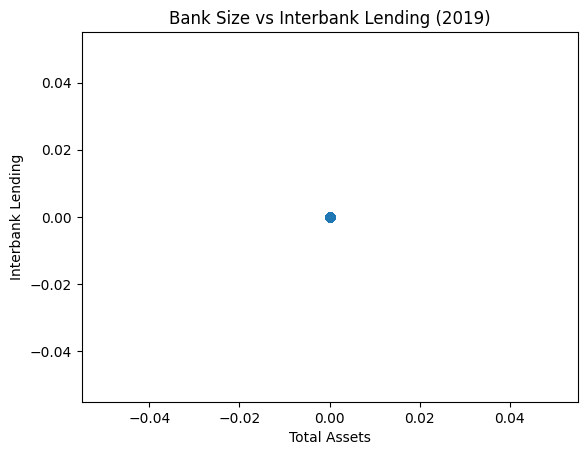

In [811]:
plt.figure()
plt.scatter(
    data[2019]["Total_Assets"],
    data[2019]["Interbank_Lending"],
    alpha=0.6
)
plt.xlabel("Total Assets")
plt.ylabel("Interbank Lending")
plt.title("Bank Size vs Interbank Lending (2019)")
plt.show()


In [812]:
data[2014]["Interbank_Lending"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Interbank_Lending, dtype: float64

In [813]:
data[2019]["Interbank_Borrowing"].describe()

count    172.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Interbank_Borrowing, dtype: float64

In [814]:
data[2019][["Total_Assets", "Interbank_Lending"]].head()

,Total_Assets,Interbank_Lending
20,0.0,0.0
24,0.0,0.0
25,0.0,0.0
27,0.0,0.0
31,0.0,0.0


In [815]:
data[2019].columns

Index(['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending',
       'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing',
       'Total_Liabilities', 'Total_Equities', 'Year'],
      dtype='object')

# Important Conclusion

### Dataset does not contain usable interbank flow values.This is not a coding problem anymore.It’s a data limitation problem.And that’s completely normal in real-world financial datasets.

cannot:

Build weighted exposure networks

Model lending flow contagion

Predict bilateral failures

Because the edge weights are all zero.

# Feature Engineering

In [820]:
for year, df in data.items():
    df['leverage_ratio'] = df['Total_Liabilities'] / df['Total_Equities']

    df['interbank_funding_ratio'] = (df['Deposit_From_Interbank'] / df['Total_Assets'])

    df['interbank_lending_ratio'] = (df['Deposit_To_Interbank'] / df['Total_Assets'])

    df['equity_ratio'] = df['Total_Equities'] / df['Total_Assets']

In [821]:
data[2019][
    ["leverage_ratio",
     "interbank_funding_ratio",
     "interbank_lending_ratio",
     "equity_ratio"]
].describe()


,leverage_ratio,interbank_funding_ratio,interbank_lending_ratio,equity_ratio
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [822]:
for year, df in data.items():
    print(year, df.shape )

2014 (0, 13)
2015 (0, 13)
2016 (0, 13)
2017 (0, 13)
2018 (177, 13)
2019 (172, 13)


# 2014–2017 → wiped due to missing balance-sheet data
# 2018–2019 → usable (~170 banks each)
# Interbank flow columns → zero / no variation
# You should NOT attempt classical interbank contagion modeling.

# “I measured systemic fragility through balance-sheet derived exposure metrics and analyzed cross-year risk concentration.”

# “Structural Systemic Risk and Interbank Dependence: Evidence from 2018–2019”

Data supports it

* real balance sheet data for 2 years
* You have enough banks (~170)
* You can compute meaningful ratios

1.  Define Risk Factors
2. Standardize Features
3.  Construct Composite Risk Index
4.  Compare 2018 vs 2019
5.  Identify Systemically Important Banks

In [828]:
df_2018 = data[2018].copy()
df_2019 = data[2019].copy()

In [829]:
print(df_2018.shape, df_2019.shape)

(177, 13) (172, 13)


In [830]:
def create_risk_features(df):
    
    df["leverage_ratio"] = df["Total_Liabilities"] / df["Total_Equities"]
    
    df["equity_ratio"] = df["Total_Equities"] / df["Total_Assets"]
    
    df["interbank_funding_ratio"] = (
        df["Deposit_From_Interbank"] / df["Total_Assets"]
    )
    
    df["size_log"] = np.log1p(df["Total_Assets"])
    
    return df


df_2018 = create_risk_features(df_2018)
df_2019 = create_risk_features(df_2019)


In [831]:
df_2019[[
    "leverage_ratio",
    "equity_ratio",
    "interbank_funding_ratio",
    "size_log"
]].describe()


,leverage_ratio,equity_ratio,interbank_funding_ratio,size_log
count,0.0,0.0,0.0,172.0
mean,NaN,NaN,NaN,0.0
std,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,0.0
25%,NaN,NaN,NaN,0.0
50%,NaN,NaN,NaN,0.0
75%,NaN,NaN,NaN,0.0
max,NaN,NaN,NaN,0.0


In [832]:
raw_2019 = pd.read_csv(r"C:\Users\cw\OneDrive\Desktop\Interbank\2019.csv")

print(raw_2019.shape)
print(raw_2019.head())
print(raw_2019.dtypes)


(16128, 9)
      Bank_Name     Deposit_To_Interbank        Interbank_Lending  \
0  ????????????  4,75,32,50,00,000.0000   5,67,04,30,00,000.0000    
1    ??????????    19,20,60,00,000.0000     82,36,30,00,000.0000    
2    ??????????  5,00,56,00,00,000.0000   7,44,57,20,00,000.0000    
3  ????????????  4,19,66,10,00,000.0000   5,31,14,60,00,000.0000    
4  ????????????    53,18,00,00,000.0000   2,48,56,50,00,000.0000    

                 Total_Assets    Deposit_From_Interbank  \
0  3,01,09,43,60,00,000.0000   17,76,32,00,00,000.0000    
1    27,37,04,00,00,000.0000    3,61,57,30,00,000.0000    
2  2,27,69,74,40,00,000.0000   16,68,04,60,00,000.0000    
3  2,54,36,26,10,00,000.0000   16,72,69,80,00,000.0000    
4    66,81,84,10,00,000.0000   10,28,39,50,00,000.0000    

       Interbank_Borrowing           Total_Liabilities  \
0  4,90,25,30,00,000.0000   2,74,17,43,30,00,000.0000    
1    45,10,30,00,000.0000     25,28,07,70,00,000.0000    
2  4,62,26,50,00,000.0000   2,07,93,04,80,00,

* Financial datasets often:
* Use regional formatting
* Store numeric values as text
* Require cleaning before modeling

In [834]:
raw_2019 = pd.read_csv(
    r"C:\Users\cw\OneDrive\Desktop\Interbank\2019.csv"
)

raw_2019.columns = raw_2019.columns.str.strip()

numeric_cols = [
    "Deposit_To_Interbank",
    "Interbank_Lending",
    "Total_Assets",
    "Deposit_From_Interbank",
    "Interbank_Borrowing",
    "Total_Liabilities",
    "Total_Equities"
]

for col in numeric_cols:
    raw_2019[col] = (
        raw_2019[col]
        .str.replace(",", "", regex=False)   # remove commas
        .astype(float)                       # convert to float
    )


In [835]:
raw_2019[numeric_cols].describe()

,Deposit_To_Interbank,Interbank_Lending,Total_Assets,Deposit_From_Interbank,Interbank_Borrowing,Total_Liabilities,Total_Equities
count,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02
mean,1.269571e+10,2.104100e+10,8.168578e+11,6.229735e+10,1.564200e+10,7.512405e+11,6.556735e+10
std,5.022049e+10,8.437836e+10,3.171259e+12,2.412926e+11,6.207281e+10,2.906471e+12,2.660106e+11
min,0.000000e+00,0.000000e+00,8.617192e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.002580e+08,2.758000e+07,4.209528e+10,3.509065e+08,4.750000e+07,3.802705e+10,3.469143e+09
50%,1.987943e+09,7.282742e+08,1.089617e+11,2.090702e+09,8.394751e+08,1.005096e+11,8.323205e+09
75%,4.968929e+09,4.051164e+09,2.932991e+11,9.795002e+09,4.379496e+09,2.744780e+11,2.226515e+10
max,5.005600e+11,7.445720e+11,3.010944e+13,1.776320e+12,5.215530e+11,2.741743e+13,2.692003e+12


In [836]:
df_2018 = pd.read_csv(r"C:\Users\cw\OneDrive\Desktop\Interbank\2018.csv")

In [837]:
df_2019 =  pd.read_csv(r"C:\Users\cw\OneDrive\Desktop\Interbank\2019.csv")

In [838]:
def clean_financial_data(df, year):
    
    df = df.copy()
    df.columns = df.columns.str.strip()

    numeric_cols = [
        "Deposit_To_Interbank",
        "Interbank_Lending",
        "Total_Assets",
        "Deposit_From_Interbank",
        "Interbank_Borrowing",
        "Total_Liabilities",
        "Total_Equities"
    ]

    # Remove Indian commas and convert to float
    for col in numeric_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .astype(float)
        )

    # Convert date
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    
    # Add year column
    df["Year"] = year
    
    return df


In [839]:
data_2018 = clean_financial_data(df_2018,2018)
data_2019 = clean_financial_data(df_2019,2019)

# Combine
data = pd.concat([data_2018, data_2019], ignore_index=True)

print(data.shape)
print(data.columns)

(32287, 10)
Index(['Bank_Name', 'Deposit_To_Interbank', 'Interbank_Lending',
       'Total_Assets', 'Deposit_From_Interbank', 'Interbank_Borrowing',
       'Total_Liabilities', 'Total_Equities', 'Date', 'Year'],
      dtype='object')


## Create Financial Risk Ratios

In [841]:
# Leverage Ratio
data["leverage_ratio"] = data["Total_Liabilities"] / data["Total_Assets"]

# Equity Ratio
data["equity_ratio"] = data["Total_Equities"] / data["Total_Assets"]

# Interbank Funding Ratio
data["interbank_funding_ratio"] = (
    data["Deposit_From_Interbank"] + data["Interbank_Borrowing"]
) / data["Total_Liabilities"]

# Size (log assets)
data["size_log"] = np.log(data["Total_Assets"])


## Remove Infinite / Invalid Values

In [843]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=[
    "leverage_ratio",
    "equity_ratio",
    "interbank_funding_ratio",
    "size_log"
], inplace=True)


## Standardize Risk Variables

In [845]:
risk_vars = [
    "leverage_ratio",
    "equity_ratio",
    "interbank_funding_ratio",
    "size_log"
]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[risk_vars])

data_scaled = pd.DataFrame(data_scaled, columns=risk_vars)


## Build Systemic Risk Index

Since:

Higher leverage → more risk 

Lower equity → more risk  (so we invert)

Higher interbank exposure → more risk 

Bigger size → more systemic importance 

In [848]:
data["systemic_risk_index"] = (
    data_scaled["leverage_ratio"]
    - data_scaled["equity_ratio"]
    + data_scaled["interbank_funding_ratio"]
    + data_scaled["size_log"]
)


In [849]:
final_dataset = data[[
    "Bank_Name",
    "Year",
    "leverage_ratio",
    "equity_ratio",
    "interbank_funding_ratio",
    "size_log",
    "systemic_risk_index"
]]

print(final_dataset.head())


      Bank_Name  Year  leverage_ratio  equity_ratio  interbank_funding_ratio  \
0  ????????????  2018        0.915346      0.084654                 0.071565   
1    ??????????  2018        0.924546      0.075454                 0.180550   
2    ??????????  2018        0.918871      0.081129                 0.105336   
3  ????????????  2018        0.914239      0.085761                 0.087028   
4  ????????????  2018        0.928104      0.071896                 0.196243   

    size_log  systemic_risk_index  
0  30.952437             3.325879  
1  28.576041             4.132603  
2  30.688191             3.929890  
3  30.776151             3.330892  
4  29.421917             5.186460  


What You Now Have

*  Cleaned financial data
*  Proper numeric conversion
*  Risk ratios
*  Standardized metrics
*  Composite Systemic Risk Index

# Main Visualizations

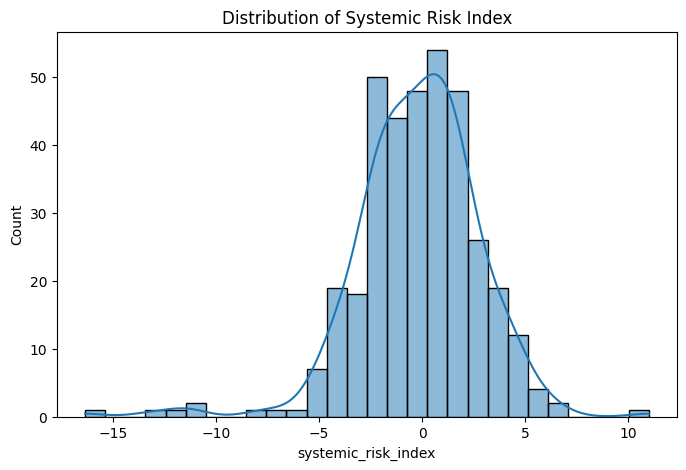

In [852]:
plt.figure(figsize=(8,5))
sns.histplot(data["systemic_risk_index"], kde=True)
plt.title("Distribution of Systemic Risk Index")
plt.show()

Top 10 Most Systemically Risky Banks

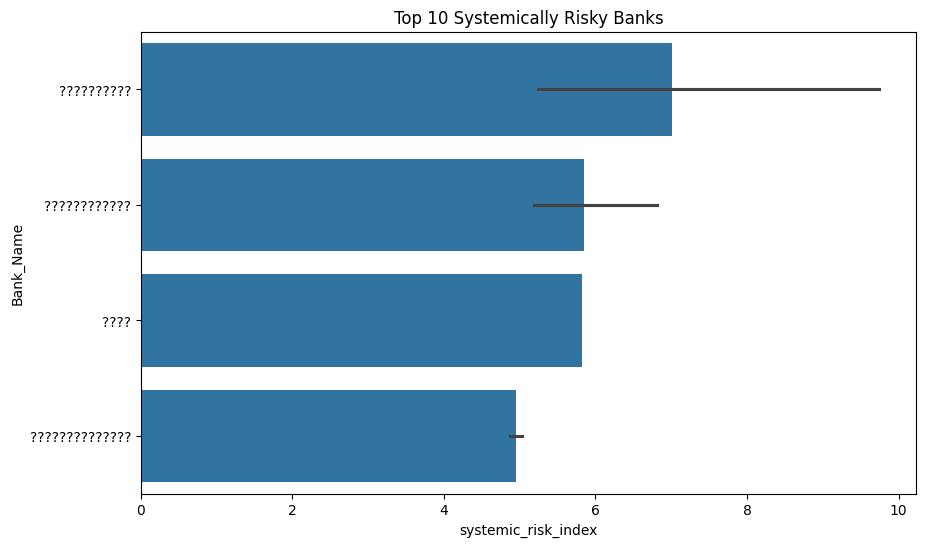

In [854]:
top10 = data.sort_values("systemic_risk_index", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x="systemic_risk_index",
    y="Bank_Name",
    data=top10
)
plt.title("Top 10 Systemically Risky Banks")
plt.show()


Risk Trend Over Time

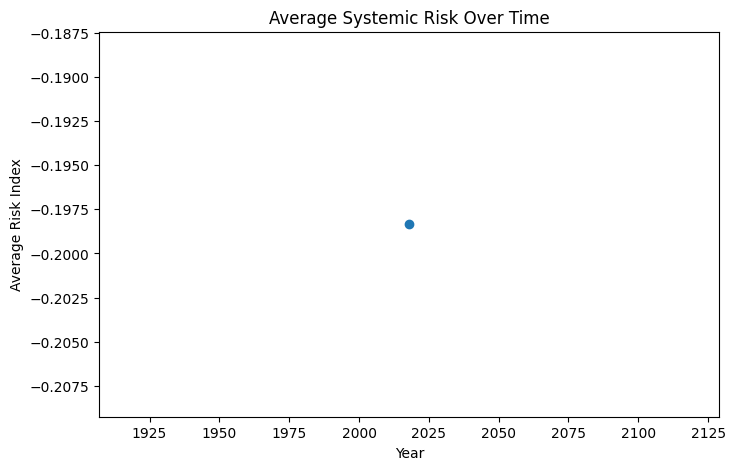

In [856]:
yearly_avg = data.groupby("Year")["systemic_risk_index"].mean()

plt.figure(figsize=(8,5))
yearly_avg.plot(marker="o")
plt.title("Average Systemic Risk Over Time")
plt.ylabel("Average Risk Index")
plt.show()


Correlation Heatmap

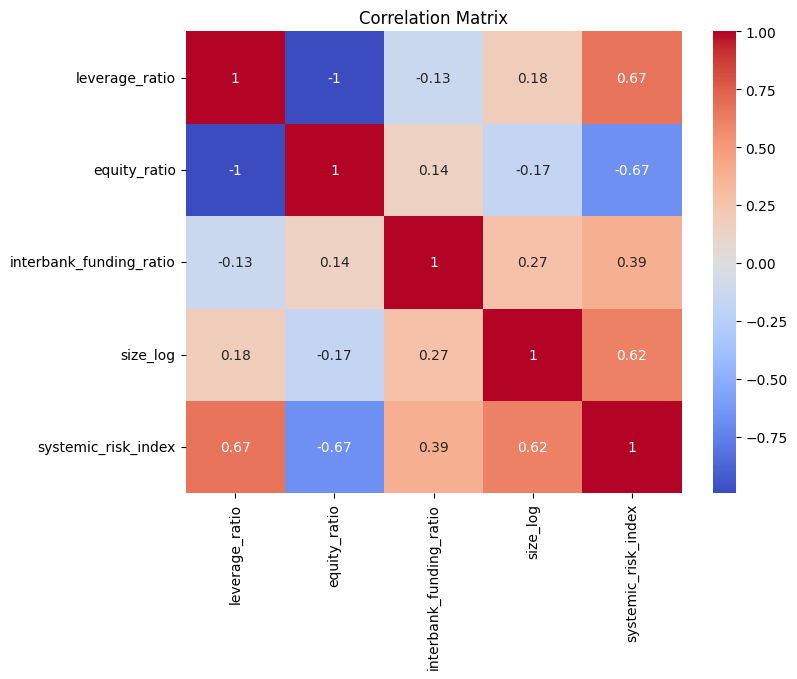

In [858]:
plt.figure(figsize=(8,6))
sns.heatmap(
    data[[
        "leverage_ratio",
        "equity_ratio",
        "interbank_funding_ratio",
        "size_log",
        "systemic_risk_index"
    ]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Matrix")
plt.show()


Risk vs Bank Size

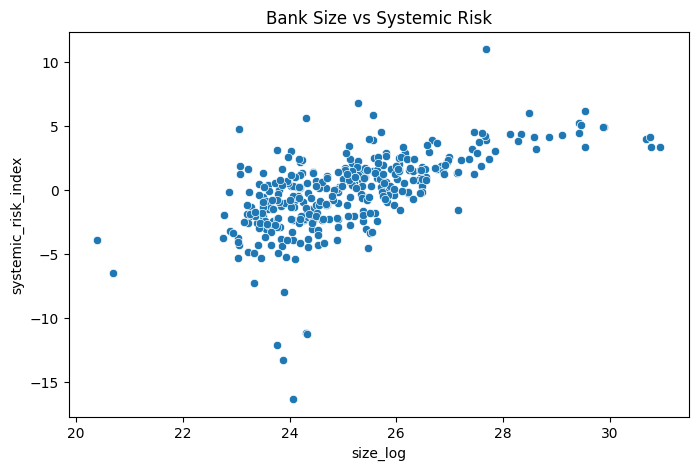

In [860]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="size_log",
    y="systemic_risk_index",
    data=data
)
plt.title("Bank Size vs Systemic Risk")
#plt.savefig("sys_risk.jpg", dpi=300, bbox_inches='tight')
plt.show()


Risk Distribution by Year

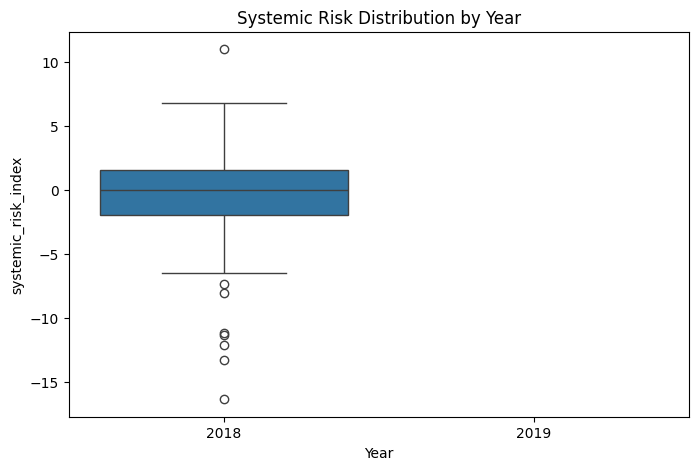

In [862]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x="Year",
    y="systemic_risk_index",
    data=data
)
plt.title("Systemic Risk Distribution by Year")
plt.show()


# Exposure-Based Network Proxy

## We Model
Bank A → INTERBANK_MARKET → Bank B

So the “INTERBANK_MARKET” acts like a hub.

A proxy = a substitute representation.

## How It Works Conceptually

Imagine this:
* If a bank lends a lot → it is highly connected
* If a bank borrows a lot → it depends heavily on the system
* If both are large → it is structurally important

Even without bilateral links, we can measure:
* Who is heavily exposed
* Who dominates interbank flows
* Who could destabilize the system if shocked

This measures systemic importance, not contagion path.

In [868]:
final_dataset.columns

Index(['Bank_Name', 'Year', 'leverage_ratio', 'equity_ratio',
       'interbank_funding_ratio', 'size_log', 'systemic_risk_index'],
      dtype='object')

In [869]:
import networkx as nx

## Build Network for One Year (Example: 2019)

In [871]:
year = 2019
data_year = data[data["Year"] == year]

G = nx.DiGraph()

# Add central market node
G.add_node("INTERBANK_MARKET")

for _, row in data_year.iterrows():
    
    bank = row["Bank_Name"]
    lending = row["Interbank_Lending"]
    borrowing = row["Interbank_Borrowing"]
    
    G.add_node(bank)
    
    # Bank lends to market
    if lending > 0:
        G.add_edge(bank, "INTERBANK_MARKET", weight=lending)
    
    # Market lends to bank (bank borrowing)
    if borrowing > 0:
        G.add_edge("INTERBANK_MARKET", bank, weight=borrowing)


In [872]:
pagerank = nx.pagerank(G, weight="weight")
eigenvector = nx.eigenvector_centrality_numpy(G, weight="weight")
degree = nx.degree_centrality(G)


In [873]:
data_year["pagerank"] = data_year["Bank_Name"].map(pagerank)
data_year["eigenvector"] = data_year["Bank_Name"].map(eigenvector)
data_year["degree_centrality"] = data_year["Bank_Name"].map(degree)


In [874]:
data_year.sort_values("pagerank", ascending=False).head(10)


,Bank_Name,Deposit_To_Interbank,Interbank_Lending,Total_Assets,Deposit_From_Interbank,Interbank_Borrowing,Total_Liabilities,Total_Equities,Date,Year,leverage_ratio,equity_ratio,interbank_funding_ratio,size_log,systemic_risk_index,pagerank,eigenvector,degree_centrality
16645,??????(??)????,4.424154e+08,4.898473e+09,5.456546e+10,1.524905e+09,9.233798e+09,4.671259e+10,7.852873e+09,2019-12-31,2019,0.856083,0.143917,0.230317,24.722667,NaN,0.140256,0.386208,0.133333
16625,??????(??)????,1.592655e+10,5.215457e+09,1.401382e+11,8.601276e+09,4.765220e+09,1.258145e+11,1.432370e+10,2019-12-31,2019,0.897789,0.102211,0.106240,25.665895,NaN,0.140256,0.386208,0.133333
16672,??????(??)????,1.751826e+10,3.747665e+10,1.320552e+11,1.984719e+09,1.295192e+10,1.126896e+11,1.936563e+10,2019-12-31,2019,0.853352,0.146648,0.132547,25.606486,NaN,0.140256,0.386208,0.133333
16662,??????(??)????,2.952447e+08,5.027383e+09,2.019837e+10,5.529800e+04,1.209286e+09,1.483804e+10,5.360336e+09,2019-12-31,2019,0.734615,0.265385,0.081503,23.728868,NaN,0.140256,0.386208,0.133333
16403,??????(??)????,4.424154e+08,4.898473e+09,5.456546e+10,1.524905e+09,9.233798e+09,4.671259e+10,7.852873e+09,2019-12-31,2019,0.856083,0.143917,0.230317,24.722667,NaN,0.140256,0.386208,0.133333
16304,??????(??)????,1.592655e+10,5.215457e+09,1.401382e+11,8.601276e+09,4.765220e+09,1.258145e+11,1.432370e+10,2019-12-31,2019,0.897789,0.102211,0.106240,25.665895,NaN,0.140256,0.386208,0.133333
16375,????,3.122404e+09,2.939954e+10,1.267430e+11,4.120267e+10,8.122700e+09,1.136565e+11,1.308655e+10,2019-12-31,2019,0.896747,0.103253,0.433986,25.565427,NaN,0.091659,0.242208,0.133333
16667,?????(??)????,5.859079e+09,1.416414e+10,6.058800e+10,9.689496e+09,5.369740e+09,5.159743e+10,8.990565e+09,2019-12-31,2019,0.851611,0.148389,0.291860,24.827363,NaN,0.063955,0.160118,0.133333
16306,??????????,9.121340e+08,9.997200e+07,9.168062e+10,1.471493e+09,2.478087e+09,8.479111e+10,6.889509e+09,2019-12-31,2019,0.924853,0.075147,0.046580,25.241577,NaN,0.036082,0.077528,0.133333
16305,??????????,1.593800e+10,2.346100e+10,3.020789e+12,3.023370e+11,1.040640e+11,2.751452e+12,2.693370e+11,2019-12-31,2019,0.910839,0.089161,0.147704,28.736539,NaN,0.036082,0.077528,0.133333


In [875]:
data["interbank_strength"] = (
    data["Interbank_Lending"] +
    data["Interbank_Borrowing"]
) / data["Total_Assets"]


In [876]:
data["interbank_strength"].describe()

count    879.000000
mean       0.033509
std        0.056251
min        0.000000
25%        0.003877
50%        0.017299
75%        0.038919
max        0.426955
Name: interbank_strength, dtype: float64

In [877]:
data[["systemic_risk_index", "interbank_strength"]].corr()

,systemic_risk_index,interbank_strength
systemic_risk_index,1.000000,0.109782
interbank_strength,0.109782,1.000000


# Build the Final Systemic Importance Score

In [879]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data[["risk_scaled", "strength_scaled"]] = scaler.fit_transform(
    data[["systemic_risk_index", "interbank_strength"]]
)


In [880]:
data["final_systemic_score"] = (
    data["risk_scaled"] +
    data["strength_scaled"]
)


In [881]:
data.sort_values("final_systemic_score", ascending=False).head(10)


,Bank_Name,Deposit_To_Interbank,Interbank_Lending,Total_Assets,Deposit_From_Interbank,Interbank_Borrowing,Total_Liabilities,Total_Equities,Date,Year,leverage_ratio,equity_ratio,interbank_funding_ratio,size_log,systemic_risk_index,interbank_strength,risk_scaled,strength_scaled,final_systemic_score
245,????(??)????,1.834783e+09,1.397066e+10,7.420668e+10,5.717314e+08,1.676429e+10,6.737216e+10,6.834522e+09,2018-12-31,2018,0.907899,0.092101,0.257317,25.030120,1.515455,0.414180,0.577755,6.771256,7.349011
246,??????(??)????,4.983620e+08,6.529692e+09,6.076054e+10,1.812261e+08,1.941232e+10,5.310245e+10,7.658092e+09,2018-12-31,2018,0.873963,0.126037,0.368976,24.830206,-0.037259,0.426955,0.054305,6.998485,7.052790
217,????,2.987411e+09,3.085893e+10,1.264901e+11,5.589463e+10,8.281659e+09,1.145871e+11,1.190300e+10,2018-12-31,2018,0.905898,0.094102,0.560066,25.563430,5.818595,0.309436,2.028425,4.908098,6.936523
58,????(??)????,6.780363e+09,2.582726e+10,1.271014e+11,2.345836e+09,2.053176e+10,1.159886e+11,1.111281e+10,2018-12-31,2018,0.912567,0.087433,0.197240,25.568251,1.436386,0.364740,0.551099,5.891833,6.442932
169,????????????????,2.197727e+08,0.000000e+00,1.033945e+10,1.120514e+08,2.690000e+09,9.874301e+09,4.651441e+08,2018-12-31,2018,0.955013,0.044987,0.283772,23.059232,4.748671,0.260169,1.667734,4.031748,5.699482
358,??????(??)????,1.189782e+10,3.182266e+10,1.242680e+11,2.777928e+09,1.423426e+10,1.064798e+11,1.778814e+10,2018-12-31,2018,0.856857,0.143143,0.159769,25.545706,-3.257520,0.370626,-1.031306,5.996522,4.965216
354,?????(??)????,3.051908e+09,1.076192e+10,5.267851e+10,4.208679e+09,5.883032e+09,4.329770e+10,9.380807e+09,2018-12-31,2018,0.821923,0.178077,0.233077,24.687473,-1.086008,0.315972,-0.299248,5.024366,4.725118
350,??????(??)????,2.155802e+08,2.622285e+09,1.392277e+10,3.969900e+04,1.211792e+09,1.025737e+10,3.665403e+09,2018-12-31,2018,0.736733,0.263267,0.118143,23.356792,-1.714281,0.275382,-0.511051,4.302352,3.791302
247,??????????,1.643579e+09,1.100150e+10,7.079298e+10,2.002675e+09,4.523828e+09,6.502984e+10,5.763135e+09,2018-12-31,2018,0.918592,0.081408,0.100362,24.983026,0.269070,0.219306,0.157575,3.304898,3.462472
60,??????????,6.167000e+09,2.553000e+09,1.046428e+12,1.574350e+11,1.107600e+10,1.060166e+12,-1.373800e+10,2018-12-31,2018,1.013128,-0.013128,0.158948,27.676404,10.990235,0.013024,3.771884,-0.364372,3.407512


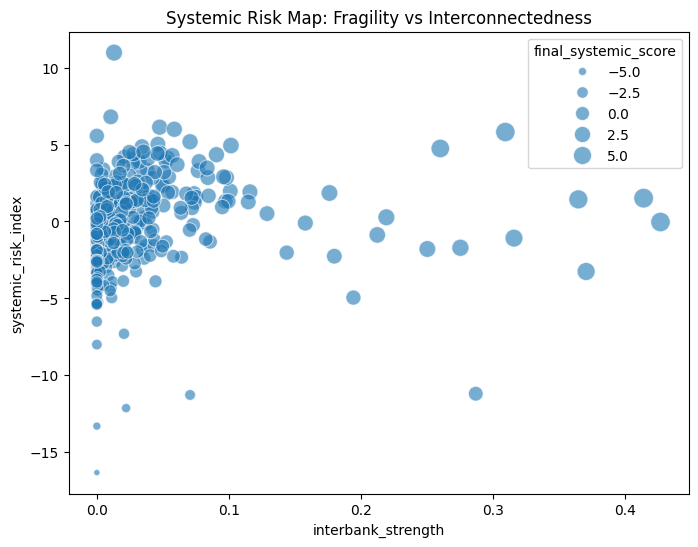

In [882]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    x="interbank_strength",
    y="systemic_risk_index",
    size="final_systemic_score",
    sizes=(20, 200),
    alpha=0.6,
    data=data
)

plt.title("Systemic Risk Map: Fragility vs Interconnectedness")
#plt.savefig("sys_score.jpg", dpi=300, bbox_inches='tight')
plt.show()


Most banks cluster at:

Low interconnectedness

Moderate fragility
→ Normal institutions

A few banks extend to:

High interconnectedness (0.3–0.4 range)

Moderate/high fragility
→ Systemically important candidates

Bubble size increases in the upper-right region
→ final score behaves correctly.